<a href="https://colab.research.google.com/github/gimhaninavodya/ResNet_Deep_Learning/blob/main/aptos_resnet101_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
!pip install -q timm albumentations==1.2.1

import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob

# Hyperparameters
CONFIG = {
    'IMG_SIZE': 256,
    'NUM_CLASSES': 5,
    'BATCH_SIZE': 16,
    'SEED': 42,

    # Phase 1: Train Freezing Backbone Head Only
    'EPOCHS_HEAD': 5,
    'LR_HEAD': 1e-4,

    # Phase 2: Fine-Tuning Full Model
    'EPOCHS_FINE_TUNE': 7,
    'LR_FINE_TUNE': 5e-6,

    'MODEL_SAVE_PATH': '/content/drive/MyDrive/aptos/models/best_resnet101.pth',
    'PATIENCE': 2,
    'LR_FACTOR': 0.5
}

# Fix randomness for reproducibility
def seed_everything(seed=CONFIG['SEED']):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Mount Drive and Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/aptos'
IMG_DIR = f'{DATA_DIR}/train_images'
CSV_PATH = f'{DATA_DIR}/train.csv'

df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)

Mounted at /content/drive
Dataset shape: (3662, 2)


# Exploratory Data Analysis (EDA)

Total images: 3662
Class counts:
 diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64
Detected image extension: .png


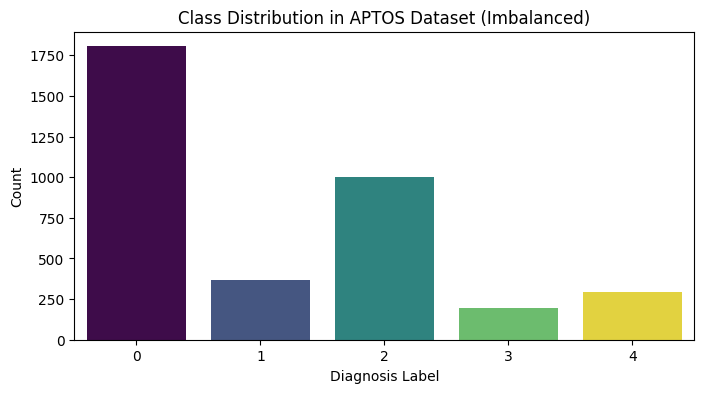

In [ ]:
print("Total images:", len(df))
print("Class counts:\n", df['diagnosis'].value_counts().sort_index())

# Detect file extension
def detect_ext(img_dir, sample_id):
    files = glob.glob(os.path.join(img_dir, sample_id + ".*"))
    return os.path.splitext(files[0])[1] if files else ".png"

ext = detect_ext(IMG_DIR, df['id_code'].iloc[0])
print("Detected image extension:", ext)

# Class Distribution Plot
plt.figure(figsize=(8,4))
sns.countplot(x='diagnosis', hue='diagnosis', data=df, palette='viridis', legend=False)
plt.title("Class Distribution in APTOS Dataset (Imbalanced)")
plt.xlabel("Diagnosis Label")
plt.ylabel("Count")
plt.show()


Showing random sample images:


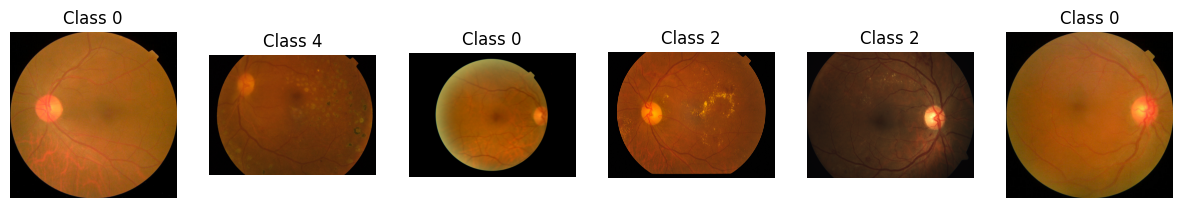

In [ ]:
# Sample Images Visualization (EDA)
def show_samples(n=6, seed=42):
    random.seed(seed)
    ids = random.sample(list(df['id_code']), n)
    plt.figure(figsize=(15, 4))
    for i, idc in enumerate(ids):
        p = os.path.join(IMG_DIR, idc + ext)
        try:
            img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.title(f"Class {df[df['id_code'] == idc]['diagnosis'].iloc[0]}")
            plt.axis("off")
        except Exception as e:
            print(f"Could not load image {idc}: {e}")

    plt.show()

print("\nShowing random sample images:")
show_samples(n=6)

# Ben Graham Preprocessing

In [ ]:
def preprocess_image_graham(image, sigmaX=30):
    image = cv2.resize(image, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_norm = cv2.addWeighted(image_bgr, 4, cv2.GaussianBlur(image_bgr, (0,0), sigmaX), -4, 128)

    H, W, C = image_norm.shape
    thresh = 10
    image_mask = cv2.cvtColor(image_norm, cv2.COLOR_BGR2GRAY) > thresh
    coords = np.argwhere(image_mask)

    if coords.size > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        image_norm = image_norm[y_min:y_max, x_min:x_max]
        image_norm = cv2.resize(image_norm, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))

    return cv2.cvtColor(image_norm, cv2.COLOR_BGR2RGB)

# Dataset Preprocessing

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=CONFIG['SEED'])

train_tfms = A.Compose([
    A.RandomResizedCrop(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),
    A.Normalize(),
    ToTensorV2()
])

class AptosDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None, ext=".png"):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.ext = ext

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{row['id_code']}{self.ext}")

        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        processed_image = preprocess_image_graham(image_rgb)

        if self.transforms:
            image = self.transforms(image=processed_image)["image"]
        else:
             image = processed_image

        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return image, label

# Instantiate datasets with the detected extension
train_dataset = AptosDataset(train_df, IMG_DIR, train_tfms, ext)
valid_dataset = AptosDataset(valid_df, IMG_DIR, valid_tfms, ext)

# Weighted sampling for class imbalance
class_counts = train_df['diagnosis'].value_counts().sort_index().tolist()
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in train_df['diagnosis']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], sampler=sampler, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['BATCH_SIZE']*2, shuffle=False, num_workers=2)

# Pretrained Model – ResNet-101

In [ ]:
def create_pretrained_resnet(num_classes=5):
    model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    # Freeze backbone initially
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

model = create_pretrained_resnet()
print("Loaded pretrained ResNet-101")

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 186MB/s]


Loaded pretrained ResNet-101


# Training utilities

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = outputs.max(1)
        total_correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/len(loader), total_correct/total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = outputs.max(1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            total_correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    acc = total_correct/total
    qwk = cohen_kappa_score(labels_all, preds_all, weights='quadratic')
    return total_loss/len(loader), acc, qwk, labels_all, preds_all

# Two-phase Training Loop

In [ ]:
history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'qwk':[]}
best_qwk = -1

# Phase 1
print("\nPhase 1: Training FC Head Only (Frozen Backbone)")
optimizer_head = optim.Adam(model.fc.parameters(), lr=CONFIG['LR_HEAD'])
scheduler_head = optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, mode='max', patience=CONFIG['PATIENCE'], factor=CONFIG['LR_FACTOR'])

for epoch in range(CONFIG['EPOCHS_HEAD']):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_head, criterion)
    val_loss, val_acc, qwk, y_true, y_pred = evaluate(model, valid_loader, criterion)
    scheduler_head.step(qwk)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['qwk'].append(qwk)

    print(f"Phase 1 | Epoch [{epoch+1}/{CONFIG['EPOCHS_HEAD']}] "
          f"TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | QWK={qwk:.4f}")

    if qwk > best_qwk:
        best_qwk = qwk
        torch.save(model.state_dict(), CONFIG['MODEL_SAVE_PATH'])
        print(f"Best model saved at QWK: {best_qwk:.4f}")


# Phase 2: Unfreeze and Fine-Tune Full Model
print("\nPhase 2: Fine-Tuning Full Model (Unfrozen Backbone)")

# Load the best weights from Phase 1 to start Phase 2 from the best point
model.load_state_dict(torch.load(CONFIG['MODEL_SAVE_PATH']))

# Unfreeze the entire network (backbone and head)
for param in model.parameters():
    param.requires_grad = True

# Create a new optimizer for ALL trainable parameters with a much lower LR
optimizer_ft = optim.Adam(model.parameters(), lr=CONFIG['LR_FINE_TUNE'])
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=CONFIG['PATIENCE'], factor=CONFIG['LR_FACTOR'])

for epoch in range(CONFIG['EPOCHS_FINE_TUNE']):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_ft, criterion)
    val_loss, val_acc, qwk, y_true, y_pred = evaluate(model, valid_loader, criterion)
    scheduler_ft.step(qwk)

    # Continue appending to history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['qwk'].append(qwk)

    print(f"Phase 2 | Epoch [{epoch+1}/{CONFIG['EPOCHS_FINE_TUNE']}] "
          f"TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | QWK={qwk:.4f}")

    if qwk > best_qwk:
        best_qwk = qwk
        torch.save(model.state_dict(), CONFIG['MODEL_SAVE_PATH'])
        print(f"Best model saved at QWK: {best_qwk:.4f}")

# Load the overall best model for final evaluation
model.load_state_dict(torch.load(CONFIG['MODEL_SAVE_PATH']))
final_val_loss, final_val_acc, final_qwk, y_true_final, y_pred_final = evaluate(model, valid_loader, criterion)

print("\nTraining Complete")
print(f"Overall Best QWK: {final_qwk:.4f}")
print(f"Overall Best Val Accuracy: {final_val_acc:.4f}")


Phase 1: Training FC Head Only (Frozen Backbone)
Phase 1 | Epoch [1/5] TrainAcc=0.5125 | ValAcc=0.6808 | QWK=0.7547
Best model saved at QWK: 0.7547
Phase 1 | Epoch [2/5] TrainAcc=0.5401 | ValAcc=0.7121 | QWK=0.7920
Best model saved at QWK: 0.7920
Phase 1 | Epoch [3/5] TrainAcc=0.5439 | ValAcc=0.7026 | QWK=0.7719
Phase 1 | Epoch [4/5] TrainAcc=0.5613 | ValAcc=0.6221 | QWK=0.7825
Phase 1 | Epoch [5/5] TrainAcc=0.5732 | ValAcc=0.7121 | QWK=0.7886

Phase 2: Fine-Tuning Full Model (Unfrozen Backbone)
Phase 2 | Epoch [1/7] TrainAcc=0.6040 | ValAcc=0.7217 | QWK=0.8065
Best model saved at QWK: 0.8065
Phase 2 | Epoch [2/7] TrainAcc=0.6419 | ValAcc=0.7326 | QWK=0.8266
Best model saved at QWK: 0.8266
Phase 2 | Epoch [3/7] TrainAcc=0.6770 | ValAcc=0.7190 | QWK=0.8325
Best model saved at QWK: 0.8325
Phase 2 | Epoch [4/7] TrainAcc=0.7030 | ValAcc=0.7531 | QWK=0.8586
Best model saved at QWK: 0.8586
Phase 2 | Epoch [5/7] TrainAcc=0.7132 | ValAcc=0.7544 | QWK=0.8552
Phase 2 | Epoch [6/7] TrainAcc=0.74

# Plot metrics

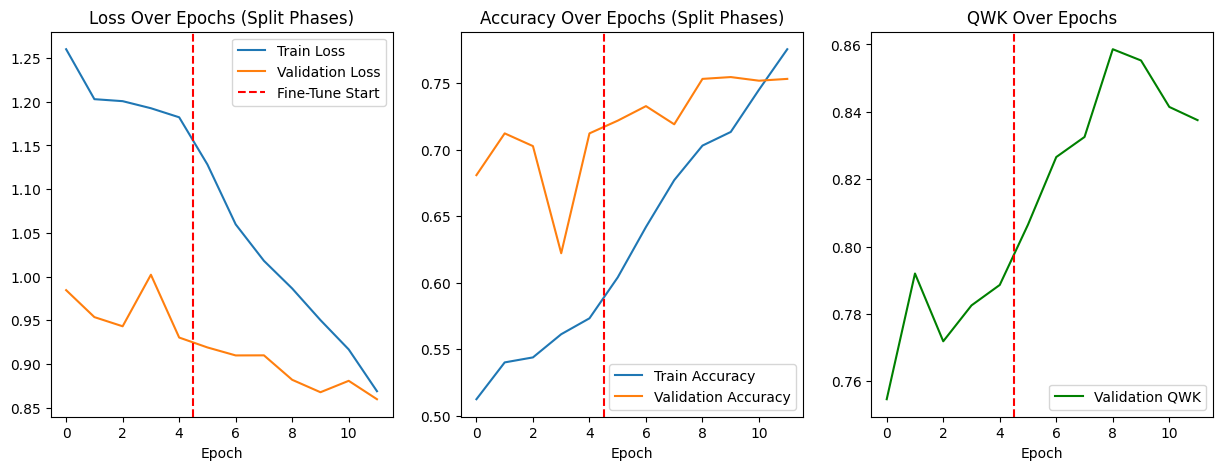

In [ ]:
num_epochs = len(history['train_loss'])
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axvline(x=CONFIG['EPOCHS_HEAD'] - 0.5, color='r', linestyle='--', label='Fine-Tune Start')
plt.title("Loss Over Epochs (Split Phases)"), plt.xlabel("Epoch"), plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.axvline(x=CONFIG['EPOCHS_HEAD'] - 0.5, color='r', linestyle='--')
plt.title("Accuracy Over Epochs (Split Phases)"), plt.xlabel("Epoch"), plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['qwk'], label='Validation QWK', color='green')
plt.axvline(x=CONFIG['EPOCHS_HEAD'] - 0.5, color='r', linestyle='--')
plt.title("QWK Over Epochs"), plt.xlabel("Epoch"), plt.legend()
plt.show()

# Confusion Matrix

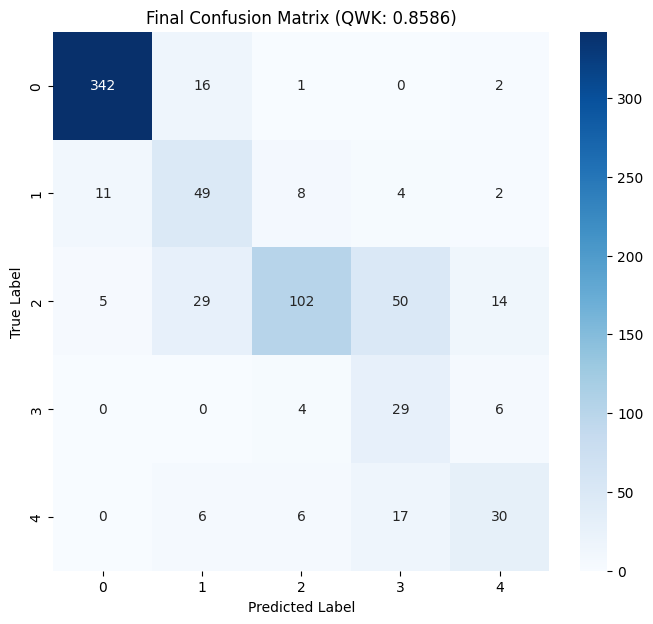

In [ ]:
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(CONFIG['NUM_CLASSES'])],
            yticklabels=[str(i) for i in range(CONFIG['NUM_CLASSES'])])
plt.title(f"Final Confusion Matrix (QWK: {final_qwk:.4f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report

In [ ]:
class_report = classification_report(
    y_true_final, y_pred_final, target_names=[str(i) for i in range(CONFIG['NUM_CLASSES'])])
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       361
           1       0.49      0.66      0.56        74
           2       0.84      0.51      0.64       200
           3       0.29      0.74      0.42        39
           4       0.56      0.51      0.53        59

    accuracy                           0.75       733
   macro avg       0.63      0.67      0.62       733
weighted avg       0.81      0.75      0.76       733

